# Fit a real flare: 2011 RHESSI M9
### You may download the data for this flare from this [Google Drive link](https://drive.google.com/file/d/1eL5cczLQX-VPCCEQDrW6WXByTcbhYdEx)

In [1]:
import astropy.units as u
import astropy.time as atime
import numpy as np
from sunkit_spex.extern import rhessi
import os

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("nice.mplstyle")

# Make the thermal emission matrix multiplications
# use fewer CPU cores
os.environ["OMP_NUM_THREADS"] = "4"

from example_support import adapt_rhessi_data
from yaff import common_likelihoods, common_models
from yaff import fitting
from yaff import plotting as yap

## First, we load the data in using `sunkit_spex.extern.rhessi.RhessiLoader` and adapt it to the target format

In [2]:
# Load in the data and set the event/background times

rl = rhessi.RhessiLoader(
    spectrum_fn="rhessi-data/trevor-flare-30-jul-2011-logspace-bkg_spec.fits",
    srm_fn="rhessi-data/trevor-flare-30-jul-2011-logspace-bkg_srm.fits",
)

start_event_time = atime.Time("2011-07-30T02:08:20")
end_event_time = atime.Time("2011-07-30T02:10:20")
start_background_time = atime.Time("2011-07-30T01:54:00")
end_background_time = atime.Time("2011-07-30T01:56:00")
rl.update_event_times(start_event_time, end_event_time)
rl.update_background_times(start_background_time, end_background_time)

# Add on a 10% systematic error
rl.systematic_error = 0.1

# Put the "sunkit-spex" format into a DataPacket
dp = adapt_rhessi_data(rl)

/home/william/dev/yaff/.venv/lib/python3.13/site-packages/sunkit_spex/extern/rhessi.py:196: UserWarning: 
do not update event times to (2011-07-30T01:50:00.000, 2011-07-30T02:20:00.000): covers attenuator state change. Don't trust this fit!
  warnings.warn(


## Next, we define the log likelihood function to use and parameters
- The `log_likelihood` enforces the "energy fitting range"---no fancy logic required to enforce this elsewhere
- The parameters are explicitly declared with units and "frozen" state. This is verbose, but the intent is clear.
- Finally, log priors are placed on the parameters. In this case, the prior is just a uniform prior (aka "bounds").

In [3]:
# Set energy bounds to restrict where we care about the likelihood
mids = dp.count_energy_edges[:-1] + np.diff(dp.count_energy_edges) / 2
energy_bounds = (mids >= 6) & (mids <= 100)
log_likelihood = common_likelihoods.chi_squared_factory(restriction=energy_bounds)


# Define the parameters with their initial guesses (all frozen to start)
starting_parameters = {
    "temperature": fitting.Parameter(10 << u.MK, frozen=True),
    "emission_measure": fitting.Parameter(1 << (1e49 * u.cm**-3), frozen=True),
    "electron_flux": fitting.Parameter(20 << (1e35 * u.electron / u.s), frozen=True),
    "spectral_index": fitting.Parameter(2 << u.one, frozen=True),
    "cutoff_energy": fitting.Parameter(20 << u.keV, frozen=True),
}

# The priors we give are just "bounds" on
# the physical values. They could be something
# more interesting like a truncated normal,
# or some other probability distribution.
log_priors = {
    "temperature": fitting.simple_bounds(0, 100),
    "emission_measure": fitting.simple_bounds(0, 1000),
    "electron_flux": fitting.simple_bounds(0, 10000),
    "spectral_index": fitting.simple_bounds(2, 10),
    "cutoff_energy": fitting.simple_bounds(1, 60),
}

# Name the parameter groups so we can loop
# over them later
thermal_names = ["temperature", "emission_measure"]
nonthermal_names = ["electron_flux", "spectral_index", "cutoff_energy"]

## Construct the actual fitter object with the data, model, priors, and likelihood.

In [4]:
def thermal_and_thick(args: dict[str, common_models.ArgsT]) -> np.ndarray:
    """Compound model: thermal emission + thick target"""
    return common_models.thermal(args) + common_models.thick_target(args)


fitta = fitting.BayesFitter(
    data=dp,
    # Model function is defined in external file
    # It's just a normal function
    model_function=thermal_and_thick,
    parameters=starting_parameters,
    log_priors=log_priors,
    log_likelihood=log_likelihood,
)

## Before proceeding to an MCMC run, we minimize the parameters using "normal" minimization
Like XSPEC, we use Levenberg-Marquadt least squares to get a good initial guess.

The Levenberg-marquadt algorithm uses all of the (data - model) residuals, rather than just a summary of the residuals, to zero-in to a (moderately) robust least squares solution.

In [5]:
print("minimize all")
for n in nonthermal_names + thermal_names:
    fitta.parameters[n].frozen = False
fitta = fitting.levenberg_minimize(fitta)

print('"best-fit" parameters are:')
fitta.parameters

minimize all
"best-fit" parameters are:


OrderedDict([('temperature', Parameter(2.26e+01, MK, frozen=False)),
             ('emission_measure',
              Parameter(1.94e+00, 1e+49 / cm3, frozen=False)),
             ('electron_flux',
              Parameter(4.92e+00, 1e+35 electron / s, frozen=False)),
             ('spectral_index', Parameter(6.05e+00, , frozen=False)),
             ('cutoff_energy', Parameter(2.35e+01, keV, frozen=False))])

## We can plot the model on top of the data to see how the "normal" minimization did

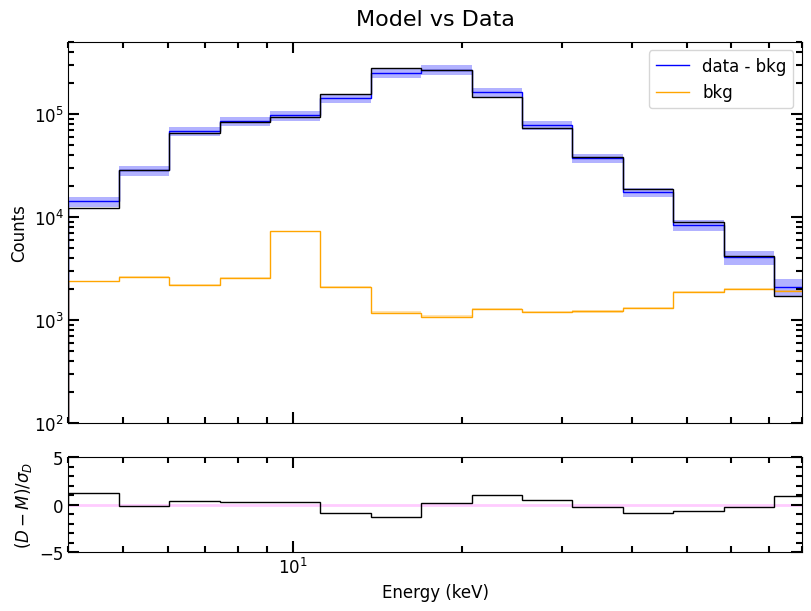

In [6]:
fig = plt.figure(figsize=(8, 6))
ret = yap.plot_data_model(fitta, fig=fig)
ret["data_ax"].set(xlim=(4, 80), ylim=(1e2, 5e5))
plt.show()

## Now that the parameters have been (quickly) minimized via chi2, we can perturb that solution with MCMC to get meaningful uncertainties

In [7]:
for n in thermal_names + nonthermal_names:
    fitta.parameters[n].frozen = False

fitta.run_emcee({"nwalkers": os.cpu_count()}, {"nsteps": 1000, "progress": True})
fitta.emplace_best_mcmc()
fitta.parameters

100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s]


OrderedDict([('temperature', Parameter(2.22e+01, MK, frozen=False)),
             ('emission_measure',
              Parameter(2.11e+00, 1e+49 / cm3, frozen=False)),
             ('electron_flux',
              Parameter(6.77e+00, 1e+35 electron / s, frozen=False)),
             ('spectral_index', Parameter(6.15e+00, , frozen=False)),
             ('cutoff_energy', Parameter(2.31e+01, keV, frozen=False))])

## Look at the parameter chains to determine the "burn-in," i.e. where the solution has converged

{'fig': <Figure size 800x1000 with 5 Axes>,
 'axes': [<Axes: title={'center': 'temperature'}, ylabel='MK'>,
  <Axes: title={'center': 'emission_measure'}, ylabel='1e+49 / cm3'>,
  <Axes: title={'center': 'electron_flux'}, ylabel='1e+35 electron / s'>,
  <Axes: title={'center': 'spectral_index'}>,
  <Axes: title={'center': 'cutoff_energy'}, ylabel='keV'>]}

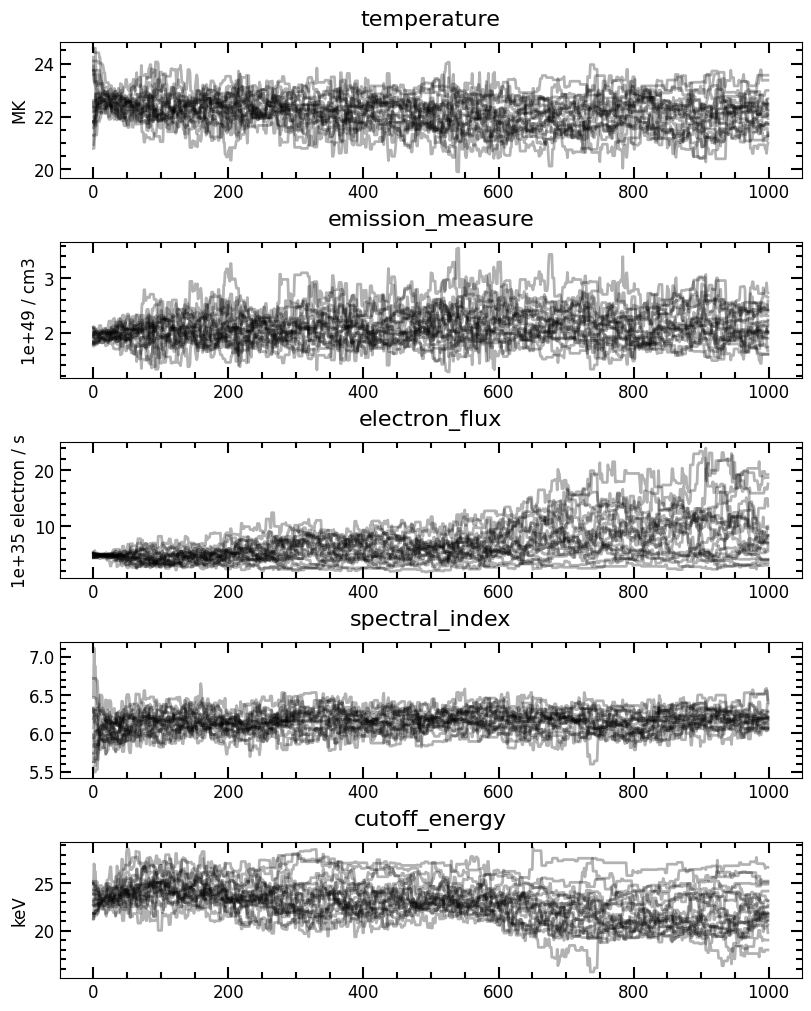

In [ ]:
fig = plt.figure(figsize=(8, 10))
names = fitta.free_param_names
ret = yap.plot_parameter_chains(
    fitta, names, fitta.free_parameters, fig=fig
)

# Modify these if you want
ret

## Make some corner plots of the parameters and annotate with 90% posterior intervals

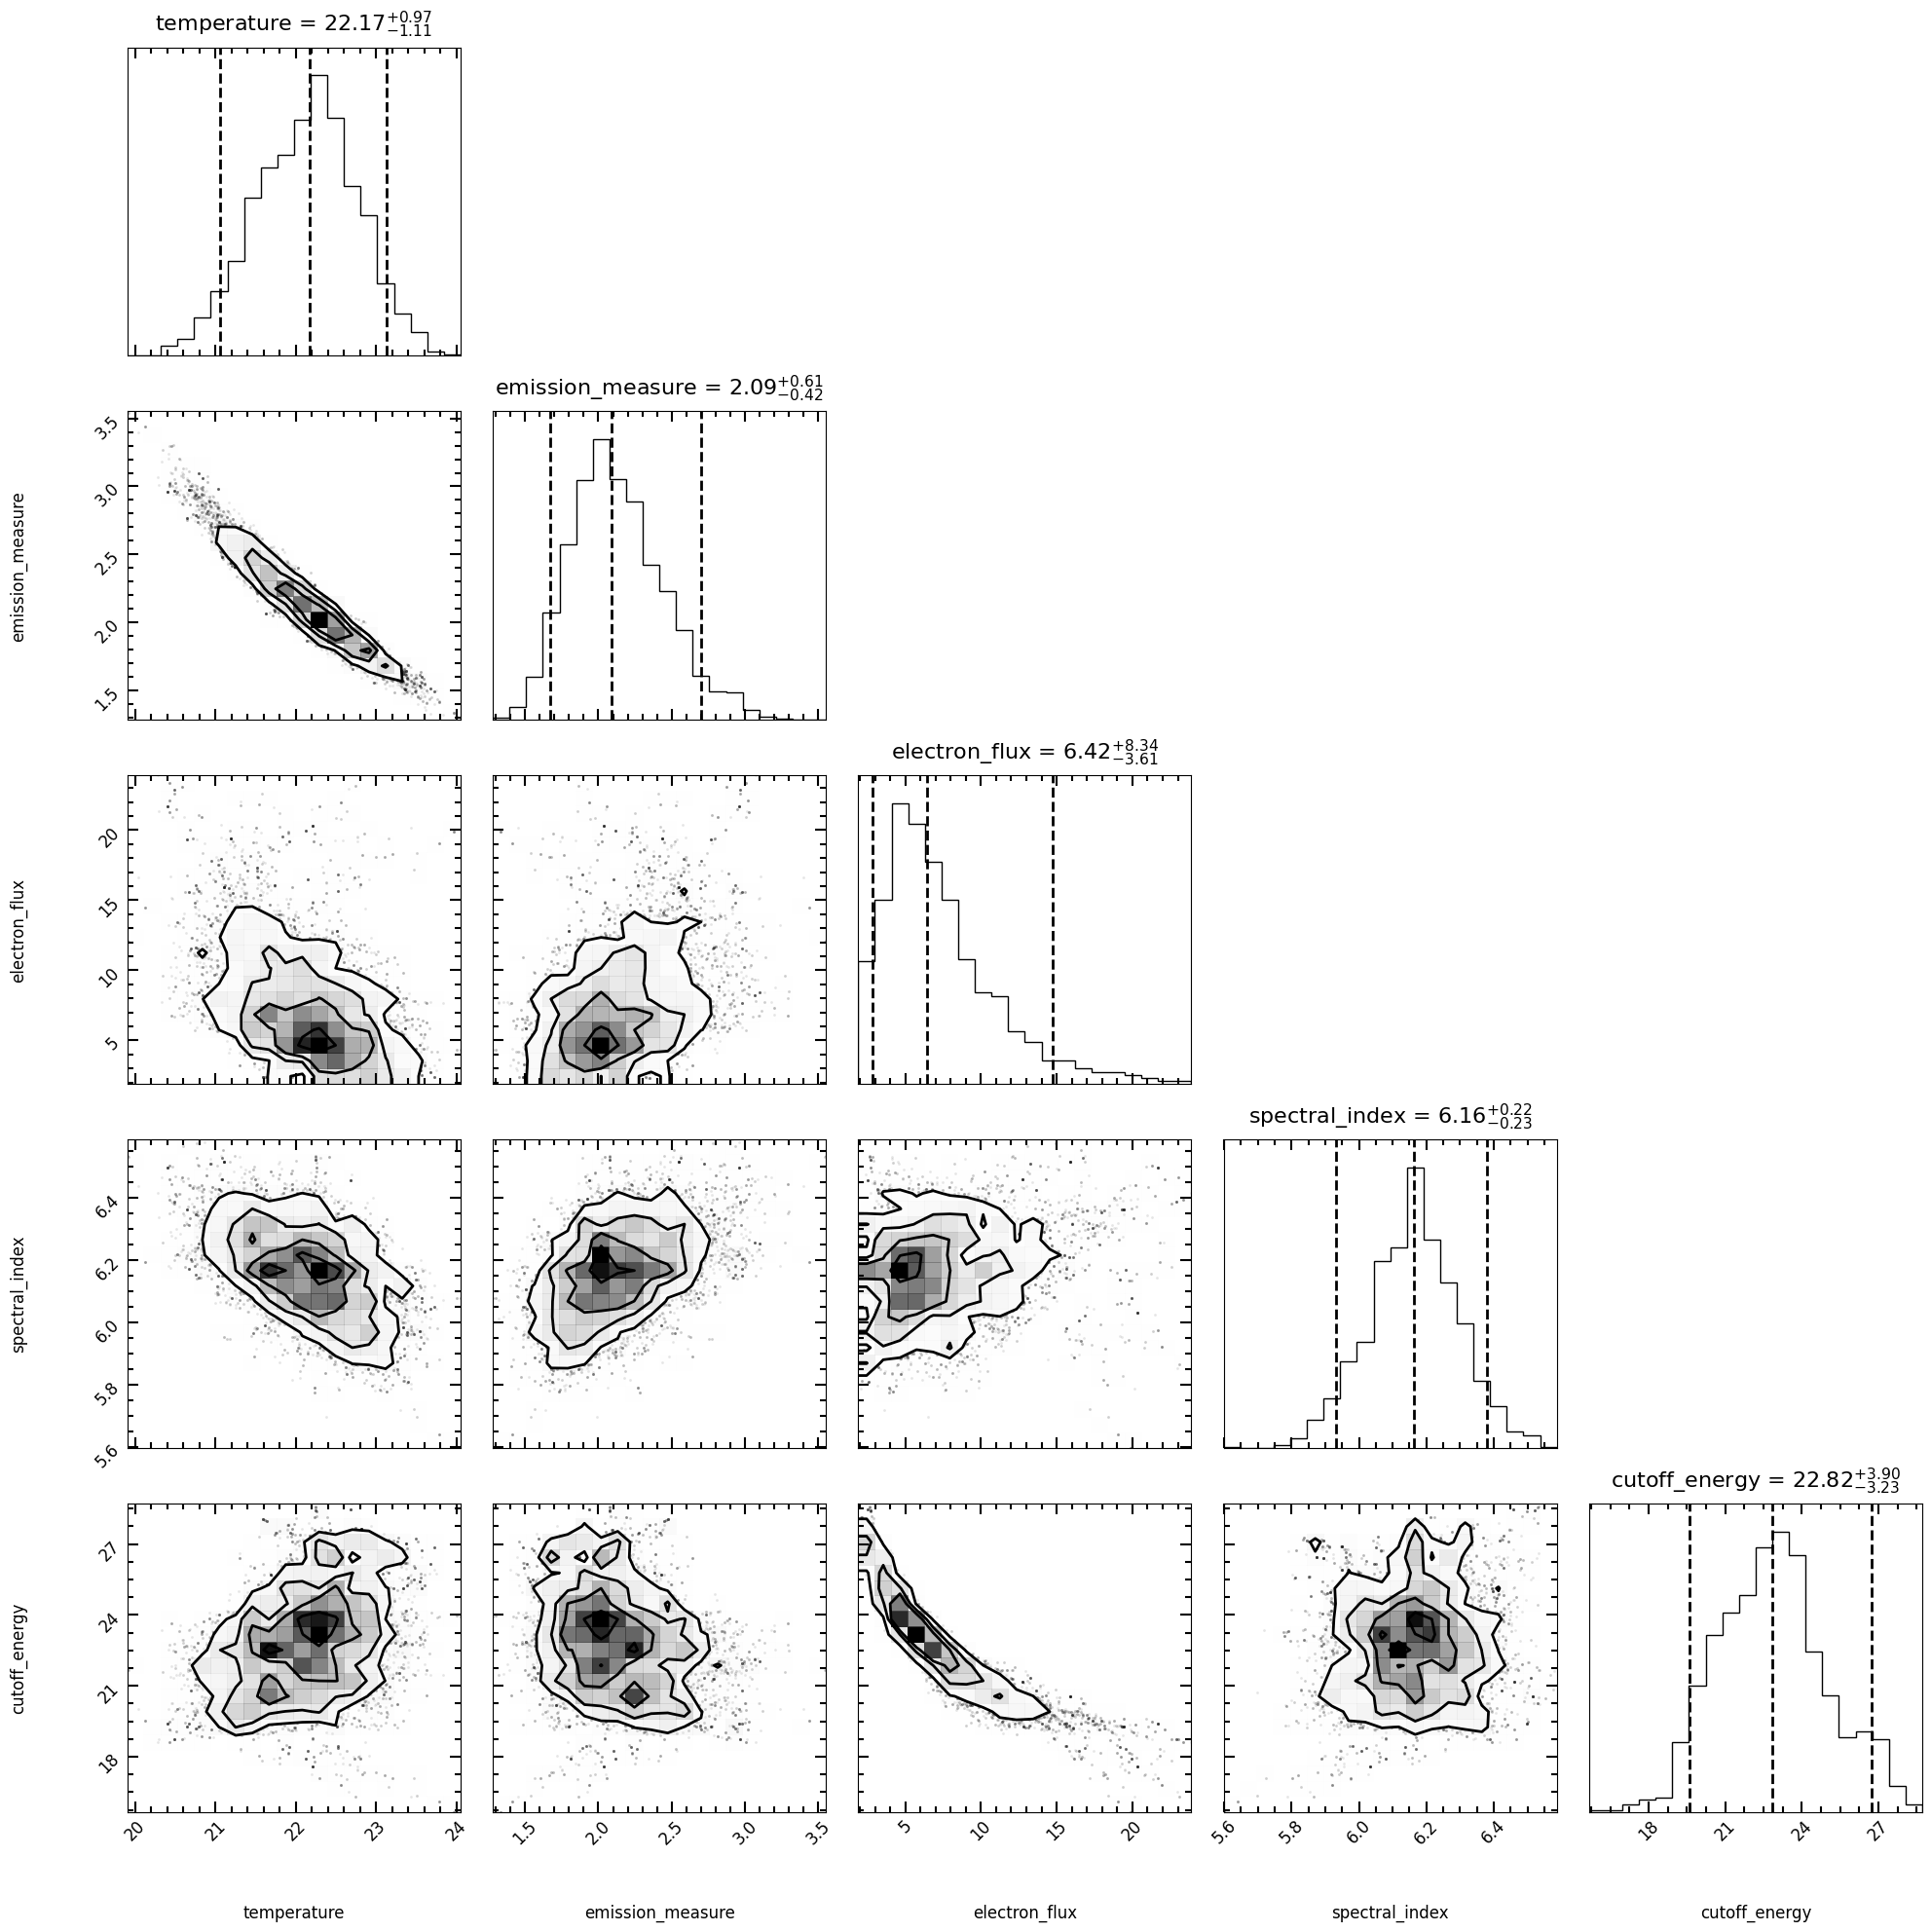

In [9]:
burn = 200 * fitta.emcee_sampler.chain.shape[0]
fig = plt.figure(figsize=(20, 20), layout="tight")
_ = yap.corner_plot(fitta, burnin=burn, fig=fig)

## Finally, plot a few (sample) models over the data. Fit seems to have worked.

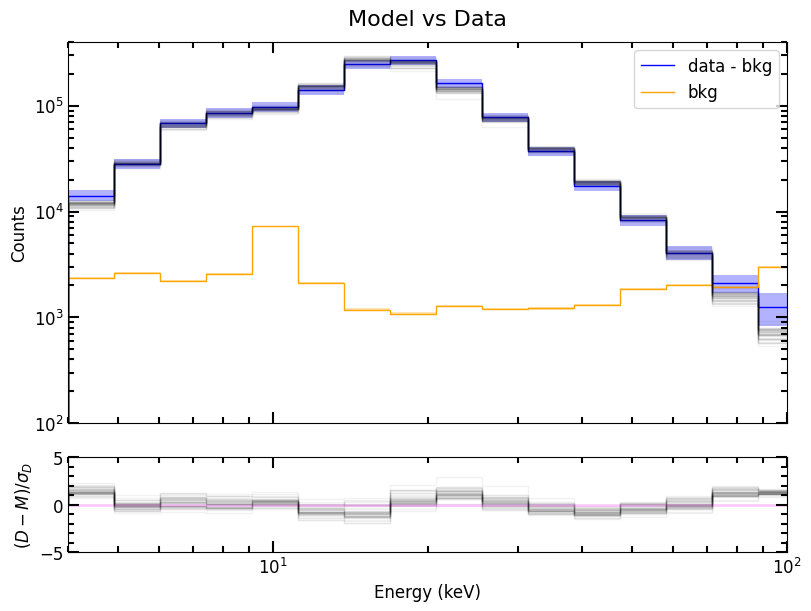

In [10]:
models = fitta.generate_model_samples(num=40)
fig = plt.figure(figsize=(8, 6))
ret = yap.plot_data_model(fitta, model_samples=models, fig=fig)
ret["data_ax"].set(xlim=(4, 100), ylim=(1e2, 4e5))
plt.show()